# PEL218 - Atividade 1
Processamento de Linguagem Narual (Prof. Guilherme Wachs)

Claudio Aparecido Borges Junior (RA 120122-7)

## Atividade
Implementar o HMM
* Objetivo: classificar Part-Of-Speech (V, N, P, DT, etc...)
* Treinar na base Folha 95 (pode ser parcial)
* Testar a classificação na base Folha 94 (pode ser parcial)
* Fazer um relatório com experimentos:
  * Precisão / Revocação / Assertividade
  * Discussão dos Resultados

## Resolução
Foi escolhida a linguagem *Python* versão 3.8.5. Os arquivos folha95 foram usados para treinamento e os folha94 para teste.

In [1]:
import collections
import math
import re

import numpy as np
import matplotlib.pyplot as plt

In [2]:
folha95_filepath = 'CHAVEFolha/cg.Folha.1995'
folha94_filepath = 'CHAVEFolha/cg.Folha.1994.reduced'

### Funções para ler, preparar e tokenizar os documentos:

`read_sentence:` lê o conteudo da tag `<s></s>` na forma de *generator*

`tokenize:` tokenização de palavras na forma de *generator* incluindo seu rótulo

In [3]:
def read_sentences(filepath):
    # Controls the position in the state machine
    with open(filepath, 'r', encoding='iso-8859-1') as file:
        sentence = []
        waiting_start = True
        for line in file:
            if waiting_start:
                if '<s>' in line:
                    waiting_start = False
            else:
                if '</s>' in line:
                    if len(sentence) > 1:
                        # Sentences should have at least 2 elements to be considered valid
                        yield sentence
                    # Reset search
                    waiting_start = True
                    sentence = []
                else:
                    # Consume the line greedly
                    sentence.append(line)

In [4]:
def tokenize(sentence, add_tag_cfg=True):
    re_word = re.compile(r'^(.+?)(?:\s|\t|$)')
    re_tag = re.compile(r'\s([A-Z]+)\s')
    
    tokens = []
    for line in sentence:
        # Word is the first part. Strip and convert to lower
        word = re_word.search(line).group(1).lower()
        if add_tag_cfg:
            maybe_tag = re_tag.search(line)
            tag = maybe_tag.group(1) if maybe_tag else 'INVTAG'
            tag_adj = '<<' + tag + '>>'
            tokens.append((word, tag_adj))
        else:
            tokens.append(word)
    return tokens

### Análise das bases de dados

In [5]:
def words_tags_counter(filepath):
    words = collections.Counter()
    tags = collections.Counter()
    for sentence in read_sentences(filepath):
        tokens = tokenize(sentence)
        words.update([token[0] for token in tokens])
        tags.update([token[1] for token in tokens])
    return words, tags

In [6]:
dict_95, tags_95 = words_tags_counter(folha95_filepath)
dict_94, tags_94 = words_tags_counter(folha94_filepath)
n_sentences_95 = sum([1 for _ in read_sentences(folha95_filepath)])
n_sentences_94 = sum([1 for _ in read_sentences(folha94_filepath)])

In [7]:
print('\nQuantidade de rótulos da Folha94 em relação a Folha95: {:.4f}%'.format(sum(dict_94.values()) / sum(dict_95.values()) * 100))
print('Quantidade de sentenças da Folha94 em relação a Folha95: {:.4f}%'.format(n_sentences_94 / n_sentences_95 * 100))

print('\nFolha95')
print('\tQuantide de exemplos:', sum(dict_95.values()))
print('\tQuantide de sentenças:', n_sentences_95)
print('\tTamanho do dicionário:', len(dict_95))
print('\tQuantidade de rótulos:', len(tags_95))
print('\t10 palavras mais frequêntes:', dict_95.most_common(10))
print('\tRótulos e sua frequência:', tags_95.most_common())
print('\nFolha94')
print('\tQuantide de exemplos:', sum(dict_94.values()))
print('\tQuantide de sentenças:', n_sentences_94)
print('\tTamanho do dicionário:', len(dict_94))
print('\tQuantidade de rótulos:', len(tags_94))
print('\t10 palavras mais frequêntes:', dict_94.most_common(10))
print('\tRótulos e sua frequência:', tags_94.most_common())


Quantidade de rótulos da Folha94 em relação a Folha95: 3.9677%
Quantidade de sentenças da Folha94 em relação a Folha95: 3.9767%

Folha95
	Quantide de exemplos: 22503737
	Quantide de sentenças: 1110070
	Tamanho do dicionário: 360858
	Quantidade de rótulos: 22
	10 palavras mais frequêntes: [('de', 1470654), ('$,', 1326374), ('a', 1251375), ('o', 1170740), ('$¶', 1110856), ('$.', 973204), ('em', 590177), ('e', 419656), ('que', 387186), ('os', 308806)]
	Rótulos e sua frequência: [('<<N>>', 4256317), ('<<DET>>', 3334266), ('<<PRP>>', 3117011), ('<<PU>>', 2717770), ('<<V>>', 2635172), ('<<INVTAG>>', 1331285), ('<<PROP>>', 1150860), ('<<ADJ>>', 1137737), ('<<ADV>>', 947293), ('<<KC>>', 517800), ('<<NUM>>', 489292), ('<<PERS>>', 279947), ('<<SPEC>>', 269511), ('<<KS>>', 268630), ('<<ALT>>', 43587), ('<<IN>>', 6596), ('<<EC>>', 655), ('<<PP>>', 4), ('<<M>>', 1), ('<<F>>', 1), ('<<IND>>', 1), ('<<S>>', 1)]

Folha94
	Quantide de exemplos: 892874
	Quantide de sentenças: 44144
	Tamanho do dicionár

Ambas bases possuem distribuições similares, porém a base de treino, a folha 95, possui 2 rótulos a mais do que a outra base sendo elas $IND$ e $S$. Porém, as 10 palavras e símbolos mais utilizas são os mesmos contendo pontuação e *stopwords*. Tais palavras e símbolos são importantes para o modelo atual já que pretendemos aprender a rotular todas as instâncias disponíveis.

Text(0.5, 1.0, 'Frequência das tags - Folha94 (Test)')

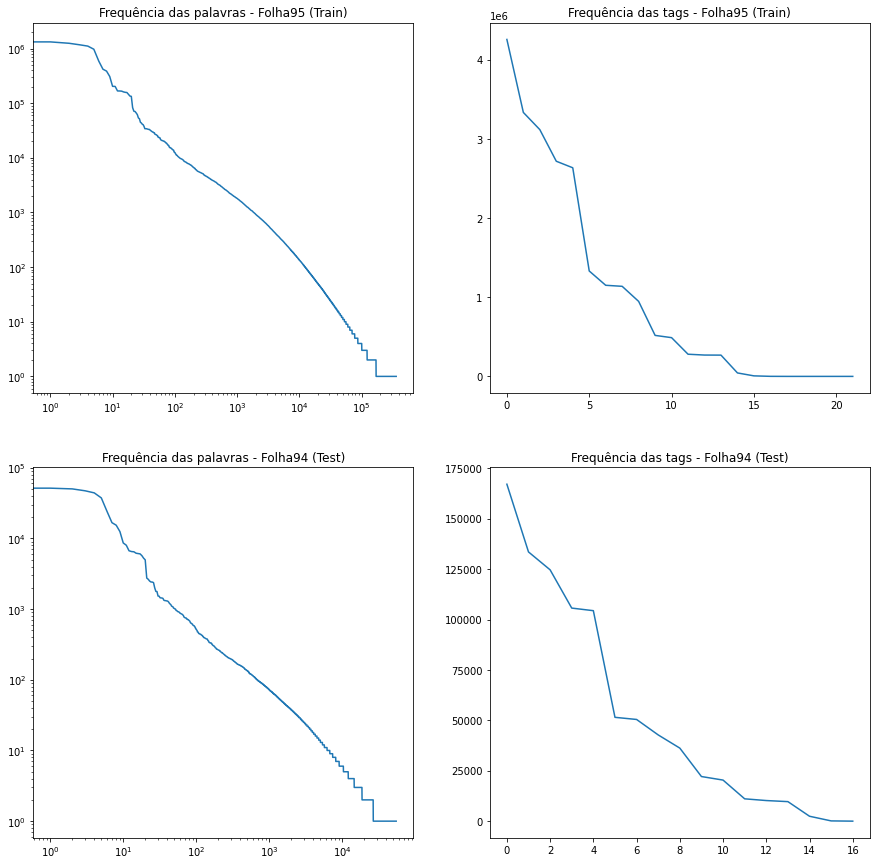

In [8]:
freq_dict_95 = freq = sorted(list(dict_95.values()), reverse=True)
freq_tags_95 = freq = sorted(list(tags_95.values()), reverse=True)
freq_dict_94 = freq = sorted(list(dict_94.values()), reverse=True)
freq_tags_94 = freq = sorted(list(tags_94.values()), reverse=True)

plt.subplots(2, 2, figsize=(15,15))
plt.subplot(2, 2, 1)
plt.plot(freq_dict_95)
plt.title('Frequência das palavras - Folha95 (Train)')
plt.xscale('log')
plt.yscale('log')

plt.subplot(2, 2, 2)
plt.plot(freq_tags_95)
plt.title('Frequência das tags - Folha95 (Train)')


plt.subplot(2, 2, 3)
plt.plot(freq_dict_94)
plt.title('Frequência das palavras - Folha94 (Test)')
plt.xscale('log')
plt.yscale('log')

plt.subplot(2, 2, 4)
plt.plot(freq_tags_94)
plt.title('Frequência das tags - Folha94 (Test)')

O gráfico mais a esquerda representa a frequência das palavras e seu decaimento. É possível reparar que a frequência das palavras diminui de forma logarítmica, tal efeito é semelhante a *Lei de Zipf ([link](https://pt.wikipedia.org/wiki/Lei_de_Zipf)), com ressalvas para as extremidades. Já os gráficos mais a direita representam a frequência dos rótulos e seu decaimento, nesse caso o decaimento não é exponêncial e sim linear nos rótulos mais utilizados. Ambas bases de dados possuem distribuições similares já que os gráficos da parte superior são parecidos com os gráficos da parte inferior.

### Modelo escondido de Markov

In [9]:
def train(sentences):
    counters = collections.Counter()
    words = set()
    tags = set()
    for sentence in sentences:
        last_word = None
        last_tag = None
        for token in tokenize(sentence):
            word = token[0]
            tag = token[1]
            # Probability of each tag
            
            counters[tag] += 1
            # Emission counters
            counters[(tag, word)] += 1
            last_word = word
            # Transitional counter
            if last_tag:
                counters[(last_tag, tag)] += 1
            last_tag = tag
            # Update the sets
            tags.add(tag)
            words.add(word)
    # Return a model. The model is the counters and the tags and the dictionary
    return counters, words, tags

In [10]:
def predict(sentence, model):
    # Use Viterbi dynamic programming
    
    # viterbi table
    m = collections.defaultdict(float)
    paths = collections.defaultdict(None)
    # Model unpacking
    counters, words, tags = model
    tokens = tokenize(sentence, add_tag_cfg=False)
    n_tokens = len(tokens)
    # Initial probability of each tag
    p_tag = {tag: counters[tag]/n_tokens for tag in tags}

    w_0 = tokens[0]
    for tag in tags:
        # Construct the viterbi table for t_0
        m[(tag, 0)] = p_tag[tag] * counters[(tag, w_0)] / counters[tag]
    
    # Calculate the viterbi for each time
    for t, w in enumerate(tokens):
        if t == 0:
            continue
        for to_tag in tags:
            m[(to_tag, t)] = -1
            for from_tag in tags:
                tmp = m[(from_tag, t-1)] \
                      * counters[(from_tag, to_tag)] / counters[from_tag] \
                      * counters[(to_tag, w)] / counters[to_tag]
                if tmp > m[(to_tag, t)]:
                    m[(to_tag, t)] = tmp
                    paths[(to_tag, t)] = from_tag
    
    # Build up output
    last = {tag: paths[(tag, n_tokens - 1)] for tag in tags}
    last = max(last, key=lambda x: last[x])
    out = [last]
    for t in range(n_tokens - 1, 0, -1):
        out.append(paths[(last, t)])
        last = paths[(last, t)]
        
    # return the predicitons os each elements of the sentence
    return list(reversed(out))

O cálculo das métricas é feita através de 3 funções, a primeira é a inicializaçao, após a acumulação e depois o cálculo das medidas. Essa divisão é necessária para que seja possível fazer predições de longas sequências de texto sem ter a necessidade de armazenas todo o resultado em memória. 

In [11]:
def score_init(model):
    # Create the confusion matrix
    _, _, tags = model
    n_tags = len(tags)
    matrix = np.zeros((n_tags, n_tags))
    tags_idx = {tag: idx for idx, tag in enumerate(tags)}
    
    return tags, tags_idx, matrix, 
    
def score_acc(labeled_predictions, score_model):
    tags, tags_idx, matrix = score_model
    
    for prediction, actual in labeled_predictions:
        actual_idx = tags_idx[actual]
        prediction_idx = tags_idx[prediction]
        matrix[actual_idx][prediction_idx] += 1
    
    return tags, tags_idx, matrix
    
def score_calc(score_model):
    tags, tags_idx, matrix = score_model
    
    # Sum the matrix in both directions (row-wise and column-wise)
    matrix_sum_axis_0 = matrix.sum(axis=0)
    matrix_sum_axis_1 = matrix.sum(axis=1)

    f1_func = lambda precision, recall: (2 * precision * recall) / (precision + recall)

    score = {}
    # Calculate the score for each label
    for tag in tags:
        idx = tags_idx[tag]
        accuracy = matrix[idx][idx] / np.sum(matrix[idx])
        precision = matrix[idx][idx] / matrix_sum_axis_1[idx]
        recall = matrix[idx][idx] / matrix_sum_axis_0[idx]
        f1 = f1_func(precision, recall)
        score[tag] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Micro averaging
    micro_avg_precision = matrix.trace() / sum(matrix_sum_axis_1)
    micro_avg_recall = matrix.trace() / sum(matrix_sum_axis_0)
    micro_avg_f1 = f1_func(micro_avg_precision, micro_avg_recall)
    score['micro-avg'] = {
        'precision': micro_avg_precision,
        'recall': micro_avg_recall,
        'f1': micro_avg_f1
    }

    # Macro averaging
    macro_avg_precision = np.mean([score[label]['precision']
                                   for label in score.keys()])
    macro_avg_recall = np.mean([score[label]['recall']
                                for label in score.keys()])
    macro_avg_f1 = f1_func(macro_avg_precision, macro_avg_recall)
    score['macro-avg'] = {
        'precision': macro_avg_precision,
        'recall': macro_avg_recall,
        'f1': macro_avg_f1
    }
    
    # Return both score (per label, micro and macro) and the confusion matrix
    return score, matrix, tags_idx,

O experimento é realizado utilizando a base de dados `Folha95` e uma amostra das primeiras 1 milhão de linhas  da `Folha94` para validação e cálculo de métricas.

In [12]:
# Train the HMM model
model = train(read_sentences(folha95_filepath))

In [13]:
# Validate the model using Folha94

score_model = score_init(model)
#sentences = [next(read_sentences(folha95_filepath))]
#for sentence in sentences:
for sentence in read_sentences(folha94_filepath):
    prediction = predict(sentence, model)

    # Create a labeled prediction
    tokens = tokenize(sentence)
    labeled_predictions = []
    for token, pred_tag in zip(tokens, prediction):
        actual = token[1]
        labeled_predictions.append((pred_tag, actual))

    # Acumulate the score
    score_model = score_acc(labeled_predictions, score_model)

# Calculate the score
score_result, matrix, tags_idx = score_calc(score_model)

<ipython-input-11-9078e3e8703e>:33: RuntimeWarning: invalid value encountered in double_scalars
  accuracy = matrix[idx][idx] / np.sum(matrix[idx])
<ipython-input-11-9078e3e8703e>:34: RuntimeWarning: invalid value encountered in double_scalars
  precision = matrix[idx][idx] / matrix_sum_axis_1[idx]
<ipython-input-11-9078e3e8703e>:35: RuntimeWarning: invalid value encountered in double_scalars
  recall = matrix[idx][idx] / matrix_sum_axis_0[idx]


In [14]:
micro_f1 = score_result['micro-avg']['f1']

print('Experimento:')
print('\tMicro-averaging f1={:.4f}\n'.format(micro_f1))

# Sort the tags by f1
scored_tags = sorted(tags_idx.keys(),
                     key=lambda x: score_result[x]['f1']
                                   if not math.isnan(score_result[x]['f1'])
                                   else 0.0,
                     reverse=True)
for tag in scored_tags:
    score = score_result[tag]
    accuracy = score['accuracy']
    precision = score['precision']
    recall = score['recall']
    f1 = score['f1']    
    print('\tRótulo {}: acurácia={:.4f}, precisão={:.4f}, revocação={:.4f}, f1={:.4f}'.format(tag, accuracy, precision, recall, f1))

Experimento:
	Micro-averaging f1=0.7749

	Rótulo <<V>>: acurácia=0.8044, precisão=0.8044, revocação=0.9825, f1=0.8846
	Rótulo <<ADV>>: acurácia=0.8056, precisão=0.8056, revocação=0.9447, f1=0.8696
	Rótulo <<N>>: acurácia=0.7772, precisão=0.7772, revocação=0.9783, f1=0.8662
	Rótulo <<DET>>: acurácia=0.7777, precisão=0.7777, revocação=0.9772, f1=0.8661
	Rótulo <<PERS>>: acurácia=0.7893, precisão=0.7893, revocação=0.9214, f1=0.8503
	Rótulo <<KC>>: acurácia=0.7364, precisão=0.7364, revocação=0.9892, f1=0.8443
	Rótulo <<INVTAG>>: acurácia=0.7120, precisão=0.7120, revocação=1.0000, f1=0.8318
	Rótulo <<ADJ>>: acurácia=0.7577, precisão=0.7577, revocação=0.9209, f1=0.8314
	Rótulo <<PU>>: acurácia=0.6868, precisão=0.6868, revocação=0.9989, f1=0.8140
	Rótulo <<NUM>>: acurácia=0.6352, precisão=0.6352, revocação=0.9820, f1=0.7714
	Rótulo <<SPEC>>: acurácia=0.7488, precisão=0.7488, revocação=0.7915, f1=0.7696
	Rótulo <<KS>>: acurácia=0.6124, precisão=0.6124, revocação=0.8823, f1=0.7230
	Rótulo <<PRO

### Análise

O experimento sobre modelo escondido de *Markov* foi realizado utilizando a base de dados `Folha95` como entrada e uma amostra da primeira 1 milhão de linhas da base de dados `Folha94` para avaliação. As bases foram divididas em sentenças delimitadas pelos símbolos $<s>$ e $</s>$; sendo que, somente sentenças maiores do que 1 unidade foram consideradas, já que o modelo necessita de ao menos 1 probabilidade de transição que é composta por no mínimo 2 variáveis.

A necessidade da sub-utilização da base de dados de avaliação é devido ao modelo de predição utilizar o algorítmo de `viterbi` que possui complexidade computacional de $O(N^2T)$, sem considerar a operação $argmax$, tornado o estudo computacionalmente denso.

O rótulo de cada símbolo foi extraído das bases de dados através da utilização de expressão regular buscando a primeira ocorrência de uma sequência de letras maiúsculas separadas por caracteres de espaço (como tabulação, quebra de linha e espaços).

Foi identificado na base de dados `Folha95` 2 rótulos adicionais a versão completa da base `Folha94`, sendo eles `<<S>>` e `<<IND>>`, cada qual com apenas 1 ocorrência, sendo o primeiro proveniente da linha `outros	 [outro] <-sam> <fmc> IND VFIN @FMV` e o segundo da linha `\t [] <-sam> S ACC`. Tal diferença não causa alterações significativas no resultado do experimento.

Os rótulos `<<PP>>`, `<<F>>`, `<<M>>`, `<<IND>>` e `<<S>>` não foram encontradas na versão reduzida da base de dados de validaçao; e as duas últimas não encontrada na versão completa como explicado no parágrafo anterior; e portanto seu desempenho é representado como `nan` na listagem acima. Dessa lista de rótulos, apenas `<<PP>>` apareceu 4 vezes na base de testes, enquanto todos os outros apareceram apenas 1 vez, indicando sua baixa utilização nessa base de dados. Exemplos de linhas são: `em=frente	 [em=frente] PP @AS<`, `pra-	 [=para+a] <hyfen> PRP_DET F S ` e `outro	 [outro] <-sam> M `.

Os 3 rótulos com maior desempenho f1 foram `<<V>>`, `<<ADV>>`, `<<N>>`, sendo eles verbos, advérbios e substantivos, sendo que todos esses símbolos estão nos 10 mais frequêntes rótulos da base de treinamento.

Os 3 rótulos com pior desempenho f1 foram `<<ALT>>`, `<<EC>>` e `<<IN>>`, sendo eles formas alternativas, prefixos e interjeicões ou representações diferentes do esperado. A última categoria tende a necessitar de uma análise semântica para identificar representaçõs diferentes do esperado e portanto modelos probabilísticos direcionados para análise sintática possuem desempenho baixa; formas alternativas possui um baixo desempenho porque seu rótulo verdadeiro é diferente desse (devido ao desempenho ruim do tokenizador) e assim sue correlação de emissão e transição é baixa. O rótulo `EC` utilizado em palavras como `pré-`, `semi-` e `ultra-` possui revocaçao alta e precisão baixa, indicando uma grande quantidade de falso-positivos.

Destaca-se também o rótul

A medida f1 *micro-averaging* foi utilizada devido ao não aparecimento de certas classes na base de treinamento. Seu desempenho ficou em 0.7268 favorecendo as classes mais frequêntes, como os 3 rótulos de maior desempenho, já que eles estão nas 5 classes mais utilizadas.